In [2]:
# -*- coding: utf-8 -*-
"""
# Turkey News: Topic Modeling and Sentiment-Topic Analysis

This Google Colab notebook focuses specifically on performing Topic Modeling (using LDA) on news articles about Turkey and then analyzing the sentiment associated with each identified topic.

## Dataset: News about Turkey from BBC, CNN, The Guardian, and FOX
Link: https://www.kaggle.com/datasets/muratiik/news-about-turkey-from-bbc-cnn-tg-and-fox

**Instructions:**
1.  **Open a brand new Google Colab notebook.**
2.  **Copy and paste all cells from this immersive block into your new notebook.**
3.  **Run each cell sequentially.**
4.  **Upload your dataset:** After running Cell 2, you will be prompted to upload the `Turkey_News.csv` file from the Kaggle dataset to your Colab environment.
5.  **Review column names:** This notebook is configured with `TEXT_COLUMN = 'content'` and `SOURCE_COLUMN = 'newsSource'`. If your CSV file has different names for these columns, you will need to adjust them in Cell 3.
6.  **Interpret Topics (Cell 6):** Pay close attention to the `pyLDAvis` output in Cell 6 to interpret the topics. You may need to adjust `NUM_TOPICS` in Cell 5.

"""

# %% [markdown]
# ### Cell 1: Install Libraries and Download NLTK Data
# This cell installs all required Python libraries (including Gensim and pyLDAvis for topic modeling) and downloads necessary NLTK data for text preprocessing.

# %%
# Install necessary libraries for data handling, NLP, and topic modeling
!pip install pandas matplotlib seaborn nltk vaderSentiment gensim pyldavis

# Import core libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

# Import specific NLP modules
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # Included if we want to run sentiment in this notebook too

# Download NLTK data components
# These are essential for preprocessing and VADER sentiment analysis
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('tokenizers/punkt') # Required for gensim.utils.simple_preprocess
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('sentiment/vader_lexicon.zip') # Required for VADER sentiment analysis
except LookupError:
    nltk.download('vader_lexicon')

print("Libraries installed and NLTK data downloaded!")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Libraries installed and NLTK data downloaded!


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [3]:
# ### Cell 2: Upload and Load Dataset
# This cell handles uploading your `Turkey_News.csv` file from your local machine to the Colab environment and then loads it into a pandas DataFrame.

# %%
# Import files module for Colab upload
from google.colab import files

# Upload the dataset
# You will be prompted to select the 'Turkey_News.csv' file.
print("Please upload your 'Turkey_News.csv' file now.")
uploaded = files.upload()

# Get the filename from the uploaded dictionary
file_name = list(uploaded.keys())[0]

# Load the dataset into a pandas DataFrame
try:
    df = pd.read_csv(file_name)
    print(f"\nDataset '{file_name}' loaded successfully!")
    print("First 5 rows of the dataset:")
    print(df.head())
    print("\nDataset Information:")
    df.info()
except Exception as e:
    print(f"Error loading the dataset: {e}")
    print("Please ensure the uploaded file is a CSV and named 'Turkey_News.csv'.")
    # %% [markdown]

Please upload your 'Turkey_News.csv' file now.


Saving Turkey_News.csv to Turkey_News.csv

Dataset 'Turkey_News.csv' loaded successfully!
First 5 rows of the dataset:
  newsSource keywords                                              title  \
0        bbc  TURKIYE                             Turkey country profile   
1        bbc  TURKIYE  Turkey earthquake: Before and after pictures s...   
2        bbc  TURKIYE  Turkey earthquake: Deadly new tremor traps peo...   
3        bbc  TURKIYE  Turkey earthquake: Death toll could increase e...   
4        bbc  TURKIYE  Turkey earthquake: Erdogan announces three-mon...   

                                             content  \
0  Once the centre of the Ottoman Empire the mode...   
1  Two huge earthquakes and a series of aftershoc...   
2  WATCH: Dashcam footage shows moment of new Tur...   
3  Dramatic social media footage from first quake...   
4  Turkey and Syria earthquake: Drone footage sho...   

                                             authour         date  \
0                 

In [4]:
# ### Cell 3: Data Preprocessing for Topic Modeling and Sentiment
# This cell cleans the text data. It's crucial for both effective topic modeling and accurate sentiment analysis.
#
# **IMPORTANT:** The `TEXT_COLUMN` and `SOURCE_COLUMN` variables are configured based on the common structure of the "News about Turkey" Kaggle dataset. Adjust them if your CSV has different column names.

# %%
# IMPORTANT:
# Adjust these column names if your CSV file uses different headers.
TEXT_COLUMN = 'content'      # Column containing the main article text
SOURCE_COLUMN = 'newsSource' # Column containing the news outlet name
DATE_COLUMN = 'date'         # Column containing the article publication date

# Initialize NLP tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
analyzer = SentimentIntensityAnalyzer() # VADER sentiment analyzer

# Define a robust text preprocessing function
def preprocess_text_for_nlp(text):
    if not isinstance(text, str): # Handle non-string types (e.g., NaN, None)
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
    text = re.sub(r'\d+', '', text) # Remove digits
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation and special characters, keep words and spaces
    return text

# Apply preprocessing to the text column
if TEXT_COLUMN not in df.columns:
    print(f"Error: Text column '{TEXT_COLUMN}' not found. Available columns: {df.columns.tolist()}")
else:
    df['cleaned_text'] = df[TEXT_COLUMN].apply(preprocess_text_for_nlp)
    print(f"\nText from '{TEXT_COLUMN}' column preprocessed and stored in 'cleaned_text'.")
    print("Sample of cleaned text:")
    print(df[[SOURCE_COLUMN, TEXT_COLUMN, 'cleaned_text']].head())

    # Perform Sentiment Analysis directly here, as it's needed for later topic-sentiment correlation
    df['vader_sentiment'] = df['cleaned_text'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

    def categorize_sentiment(score):
        if score >= 0.05: return 'Positive'
        elif score <= -0.05: return 'Negative'
        else: return 'Neutral'
    df['sentiment_category'] = df['vader_sentiment'].apply(categorize_sentiment)
    print("\nVADER sentiment scores and categories calculated.")
# %% [markdown]



Text from 'content' column preprocessed and stored in 'cleaned_text'.
Sample of cleaned text:
  newsSource                                            content  \
0        bbc  Once the centre of the Ottoman Empire the mode...   
1        bbc  Two huge earthquakes and a series of aftershoc...   
2        bbc  WATCH: Dashcam footage shows moment of new Tur...   
3        bbc  Dramatic social media footage from first quake...   
4        bbc  Turkey and Syria earthquake: Drone footage sho...   

                                        cleaned_text  
0  once the centre of the ottoman empire the mode...  
1  two huge earthquakes and a series of aftershoc...  
2  watch dashcam footage shows moment of new turk...  
3  dramatic social media footage from first quake...  
4  turkey and syria earthquake drone footage show...  

VADER sentiment scores and categories calculated.


In [6]:
# ### Cell 4: Prepare Data for Topic Model (Gensim)
# This cell tokenizes the cleaned text, forms bigrams and trigrams, and creates the dictionary and corpus required for LDA modeling with Gensim.

# %%
import gensim
from gensim import corpora

# Function to further process words (tokenize, remove stopwords, lemmatize)
def process_words_for_gensim(texts, stop_words, lemmatizer):
    for text in texts:
        if isinstance(text, str) and text.strip(): # Ensure text is a non-empty string
            # gensim.utils.simple_preprocess performs tokenization and lowercasing
            yield [lemmatizer.lemmatize(word) for word in gensim.utils.simple_preprocess(text) if word not in stop_words]
        else:
            yield [] # Yield empty list for empty/invalid entries

# Create a list of processed texts (documents) for Gensim
data_words_gensim = list(process_words_for_gensim(df['cleaned_text'], stop_words, lemmatizer))

# Build the bigram and trigram models
# min_count: Ignore all words/bigrams with total occurrence lower than this.
# threshold: Higher threshold -> fewer phrases. Adjust if too many/few bigrams/trigrams are formed.
bigram = gensim.models.Phrases(data_words_gensim, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words_gensim], threshold=100)

# Apply the phrase models to form bigrams and trigrams efficiently
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Bigrams and Trigrams for topic modeling
# Using trigrams as a default for potentially richer topics
data_words_final = make_trigrams(data_words_gensim)

# Create Dictionary (mapping unique words to IDs)
id2word = corpora.Dictionary(data_words_final)

# Filter out extreme words (very rare or very common)
# no_below: Remove tokens that appear in fewer than X documents.
# no_above: Remove tokens that appear in more than X (fraction) of documents.
# keep_n: Keep only the most frequent N tokens.
id2word.filter_extremes(no_below=10, no_above=0.5, keep_n=100000)

# Create Corpus (Bag-of-Words representation)
# Converts each document into a list of (word_id, word_count) tuples.
corpus = [id2word.doc2bow(text) for text in data_words_final]

print(f"\nPrepared {len(corpus)} documents for topic modeling.")
print(f"Dictionary contains {len(id2word)} unique tokens after filtering.")
print("Sample of first document's BoW representation:", corpus[0] if corpus else "Corpus is empty.")

# Check if corpus is empty or invalid
if not corpus:
    print("Warning: Corpus is empty. Topic modeling cannot be performed in subsequent cells.")
elif not id2word:
    print("Warning: Dictionary is empty. Topic modeling cannot be performed in subsequent cells.")
elif any(not doc for doc in corpus):
    print("Note: Some documents in the corpus are empty. This is expected if original 'content' was empty or heavily filtered.")


# %% [markdown]


Prepared 8386 documents for topic modeling.
Dictionary contains 21152 unique tokens after filtering.
Sample of first document's BoW representation: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 2), (26, 1), (27, 2), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 2), (60, 1), (61, 1), (62, 1), (63, 2), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 3), (91, 1), (92, 1), (93, 1), (94, 2), (95, 

In [7]:
# ### Cell 5: Run Topic Model (LDA)
# This cell trains the Latent Dirichlet Allocation (LDA) model using the prepared corpus and dictionary.
#
# **IMPORTANT:** You might need to experiment with `NUM_TOPICS` to find the most coherent and interpretable topics for your dataset. A value between 5 and 15 is often a good starting point. Adjusting `passes` can also affect model quality.

# %%
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaMulticore # Using LdaMulticore for faster training if available

# Number of topics to generate (adjust as needed)
NUM_TOPICS = 10 # Experiment with this value (e.g., 5, 8, 12, 15). Rerun this cell and Cell 6-7.

# Train the LDA model
try:
    if not corpus or not id2word:
        raise ValueError("Corpus or Dictionary is empty. Cannot train LDA model.")

    lda_model = LdaMulticore(corpus=corpus,
                             id2word=id2word,
                             num_topics=NUM_TOPICS,
                             random_state=100, # For reproducibility
                             chunksize=100,    # Number of documents to be used in each training chunk
                             passes=10,        # Number of passes through the entire corpus
                             per_word_topics=True, # Needed for pyLDAvis
                             workers=None)     # Use all available cores (or specify an integer)

    print(f"\nLDA model trained with {NUM_TOPICS} topics.")
    print("Top 10 words for each topic (most relevant keywords):")
    for idx, topic in lda_model.print_topics(num_words=10):
        print(f"Topic {idx}: {topic}")

    # Calculate Coherence Score (a measure of topic interpretability)
    # A higher coherence score indicates more interpretable topics.
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_final, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f"\nModel Coherence Score (c_v): {coherence_lda}")

except ValueError as ve:
    print(f"Error training LDA model: {ve}")
except Exception as e:
    print(f"An unexpected error occurred during LDA training: {e}")
    print("Ensure previous cells ran successfully and data structures (corpus, id2word) are valid.")


LDA model trained with 10 topics.
Top 10 words for each topic (most relevant keywords):
Topic 0: 0.021*"israel" + 0.013*"israeli" + 0.012*"player" + 0.012*"team" + 0.011*"game" + 0.009*"first" + 0.009*"palestinian" + 0.008*"egypt" + 0.008*"football" + 0.008*"sweden"
Topic 1: 0.033*"syria" + 0.022*"syrian" + 0.017*"isi" + 0.017*"force" + 0.016*"group" + 0.015*"attack" + 0.013*"kurdish" + 0.012*"military" + 0.012*"turkish" + 0.008*"official"
Topic 2: 0.008*"health" + 0.007*"according" + 0.007*"million" + 0.006*"price" + 0.006*"new" + 0.006*"company" + 0.006*"report" + 0.005*"world" + 0.005*"australia" + 0.005*"may"
Topic 3: 0.010*"president" + 0.010*"turkish" + 0.010*"trump" + 0.008*"state" + 0.008*"erdogan" + 0.007*"party" + 0.006*"election" + 0.006*"official" + 0.005*"journalist" + 0.005*"political"
Topic 4: 0.035*"turkish" + 0.021*"istanbul" + 0.017*"city" + 0.013*"police" + 0.010*"ankara" + 0.009*"building" + 0.006*"killed" + 0.006*"street" + 0.006*"erdogan" + 0.005*"authority"
Topi

In [8]:
# -*- coding: utf-8 -*-
# %% [markdown]
# ### Cell 6: Analyze and Interpret Topics (Save & Download HTML Visualization)
# This cell generates the interactive LDA topic visualization using `pyLDAvis` and **saves it as an HTML file**, then provides a link to download it. This is a more robust way to view the visualization if it's not rendering directly in the Colab output.
#
# **Instructions:**
# 1.  Run this cell.
# 2.  Wait for the cell to complete. It will print a message and potentially offer a download link.
# 3.  **Click the download link** that appears in the output.
# 4.  Once downloaded, **open the `.html` file in your web browser** to interact with the topic visualization.
# 5.  Based on the keywords and topic relationships, manually assign a descriptive name to each topic for your social science paper.

# %%
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis # Correct import for newer gensim versions
from google.colab import files # Import files module for downloading

html_output_filename = 'lda_topic_visualization.html'

try:
    if 'lda_model' not in locals() or not lda_model:
        raise ValueError("LDA model not trained. Please run Cell 5 first.")
    if not corpus or not id2word:
        raise ValueError("Corpus or Dictionary is empty. Please run Cell 4 first.")

    # Prepare the interactive visualization
    # We don't use enable_notebook() or display() if we're saving to HTML
    vis = gensimvis.prepare(lda_model, corpus, id2word)

    # Save the visualization as an HTML file
    pyLDAvis.save_html(vis, html_output_filename)
    print(f"\nInteractive LDA topic visualization saved as '{html_output_filename}'.")

    # Provide a link to download the file directly
    print(f"You can download the visualization using the link below:")
    files.download(html_output_filename)

    print("\nOnce downloaded, open the HTML file in your web browser to view the interactive plot.")

except ValueError as ve:
    print(f"Error generating pyLDAvis visualization: {ve}")
except Exception as e:
    print(f"An unexpected error occurred during pyLDAvis visualization: {e}")
    print("Ensure Cell 5 (LDA model training) ran successfully and 'corpus' and 'id2word' are valid.")


Interactive LDA topic visualization saved as 'lda_topic_visualization.html'.
You can download the visualization using the link below:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Once downloaded, open the HTML file in your web browser to view the interactive plot.



Dominant topics assigned to each article.
Sample with assigned topics and sentiment:
  newsSource                                              title  \
0        bbc                             Turkey country profile   
1        bbc  Turkey earthquake: Before and after pictures s...   
2        bbc  Turkey earthquake: Deadly new tremor traps peo...   
3        bbc  Turkey earthquake: Death toll could increase e...   
4        bbc  Turkey earthquake: Erdogan announces three-mon...   

   Dominant_Topic  Perc_Contribution  \
0               3             0.4370   
1               7             0.5285   
2               7             0.5509   
3               7             0.5944   
4               7             0.4776   

                                      Topic_Keywords sentiment_category  
0  president, turkish, trump, state, erdogan, par...           Negative  
1  refugee, syria, earthquake, border, syrian, ch...           Negative  
2  refugee, syria, earthquake, border, syrian, c

<ipython-input-9-3264449166>:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Dominant_Topic', y='vader_sentiment', data=sentiment_by_topic, palette='coolwarm')


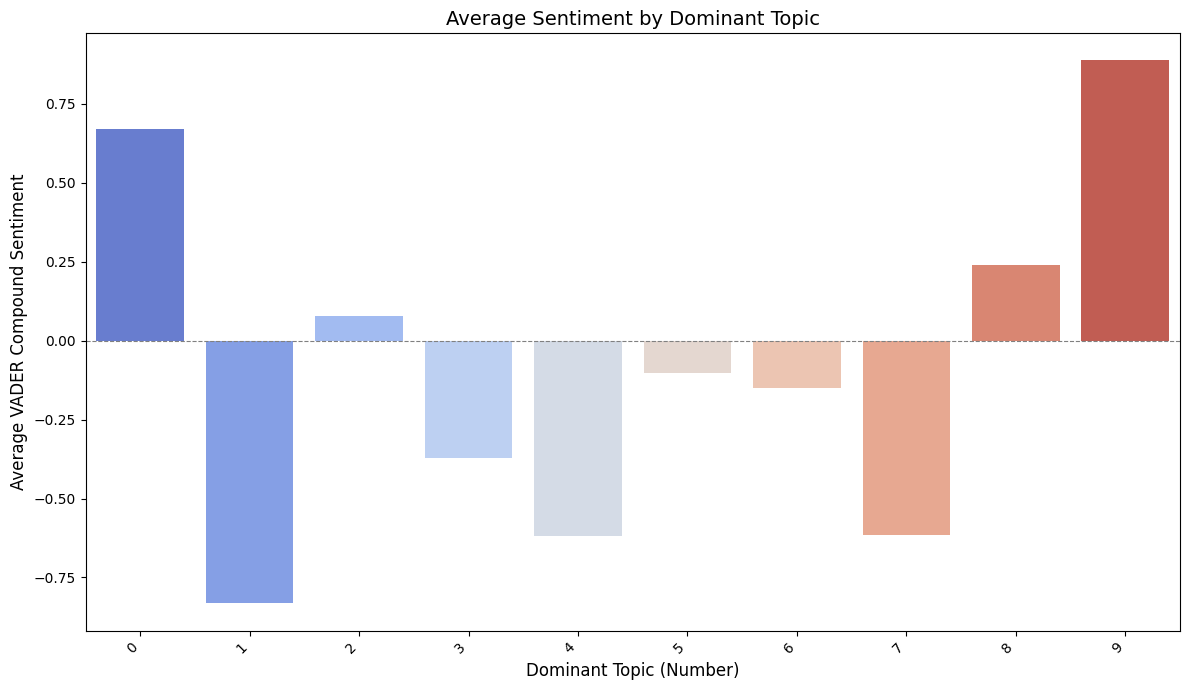

In [9]:
# ### Cell 7: Assign Dominant Topics to Articles and Analyze Sentiment by Topic
# This cell assigns the most dominant topic to each original article based on the LDA model's output. It then calculates and visualizes the average sentiment for each dominant topic, allowing you to link specific topics to positive, neutral, or negative sentiment.

# %%
# Function to get the dominant topic for each document
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output DataFrame
    sent_topics_df = pd.DataFrame()

    # Get main topic for each document
    for i, row_list in enumerate(ldamodel[corpus]):
        if not row_list: # Handle empty documents/rows in corpus
            sent_topics_df = pd.concat([sent_topics_df, pd.DataFrame([[None, 0.0, "No Topic Found"]])], ignore_index=True)
            continue

        # Get the topic distribution for the current document
        # ldamodel[corpus] can return (topic_distribution, word_topics) or just topic_distribution
        # We want the main topic distribution, which is usually the first element if per_word_topics is True
        topic_distribution = row_list[0] if ldamodel.per_word_topics else row_list

        # Sort topics by their probability contribution in descending order
        topic_distribution = sorted(topic_distribution, key=lambda x: (x[1]), reverse=True)

        # Get the Dominant Topic (highest probability), its Percentage Contribution, and Keywords
        dominant_topic_num, prop_topic = topic_distribution[0] # Take the top topic

        wp = ldamodel.show_topic(dominant_topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])

        sent_topics_df = pd.concat([sent_topics_df, pd.DataFrame([[int(dominant_topic_num), round(prop_topic,4), topic_keywords]])], ignore_index=True)

    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text (cleaned) for reference if needed
    contents = pd.Series(texts).reset_index(drop=True) # Reset index to ensure alignment
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

try:
    if 'df' not in locals() or df.empty:
        raise ValueError("DataFrame 'df' not loaded or is empty. Please run Cell 2 first.")
    if 'lda_model' not in locals() or not lda_model:
        raise ValueError("LDA model not trained. Please run Cell 5 first.")
    if not corpus:
        raise ValueError("Corpus is empty. Please run Cell 4 first.")

    # Get the dominant topic and its percentage contribution for each document
    # Pass df['cleaned_text'] directly as it's the preprocessed input
    df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['cleaned_text'])

    # The format_topics_sentences returns a DataFrame with same number of rows as corpus/texts
    # Now merge it back to the original df using index
    df_with_topics = df.copy() # Make a copy to avoid modifying original df directly

    # Ensure indexes align for merge
    df_with_topics.reset_index(drop=True, inplace=True)
    df_topic_sents_keywords.reset_index(drop=True, inplace=True)

    df_with_topics = pd.concat([df_with_topics, df_topic_sents_keywords], axis=1)


    print("\nDominant topics assigned to each article.")
    print("Sample with assigned topics and sentiment:")
    # Display relevant columns for checking
    print(df_with_topics[[SOURCE_COLUMN, 'title', 'Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'sentiment_category']].head())

    # --- Analyze Average Sentiment by Dominant Topic ---
    print("\nAnalyzing average sentiment for each dominant topic:")
    sentiment_by_topic = df_with_topics.groupby('Dominant_Topic')['vader_sentiment'].mean().reset_index()
    sentiment_by_topic = sentiment_by_topic.sort_values(by='vader_sentiment', ascending=False)

    # Merge topic keywords for better interpretation in the table
    # Get unique topics and their keywords from df_topic_sents_keywords
    topic_keywords_map = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates().set_index('Dominant_Topic')['Topic_Keywords'].to_dict()
    sentiment_by_topic['Topic_Keywords'] = sentiment_by_topic['Dominant_Topic'].map(topic_keywords_map)

    print(sentiment_by_topic)

    # Plot average sentiment by dominant topic
    plt.figure(figsize=(12, 7))
    sns.barplot(x='Dominant_Topic', y='vader_sentiment', data=sentiment_by_topic, palette='coolwarm')
    plt.title('Average Sentiment by Dominant Topic', fontsize=14)
    plt.xlabel('Dominant Topic (Number)', fontsize=12)
    plt.ylabel('Average VADER Compound Sentiment', fontsize=12)
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Neutrality line
    plt.xticks(rotation=45, ha='right') # Rotate labels for readability
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()

except ValueError as ve:
    print(f"Error: {ve}")
except Exception as e:
    print(f"An unexpected error occurred in Cell 7: {e}")
    print("Ensure all previous cells ran successfully, especially LDA model training (Cell 5) and data preparation (Cell 4).")



Streaming output truncated to the last 5000 lines.
<ipython-input-10-1817659487>:16: FutureWarning: Parsed string "10:02 PM EDT, Wed May 17, 2017" included an un-recognized timezone "EDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df_with_topics[DATE_COLUMN] = pd.to_datetime(df_with_topics[DATE_COLUMN], errors='coerce')
<ipython-input-10-1817659487>:16: FutureWarning: Parsed string "11:35 AM EDT, Sun March 8, 2020" included an un-recognized timezone "EDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df_with_topics[DATE_COLUMN] = pd.to_datetime(df_with_topics[DATE_COLUMN], errors='coerce')
<ipython-input-10-1817659487>:16: FutureWarning: Parsed string "11:37 PM EDT, Tue October 22, 2019" included


Visualizing: Dominant Topics Over Time (Annually Proportion)


<Figure size 1600x900 with 0 Axes>

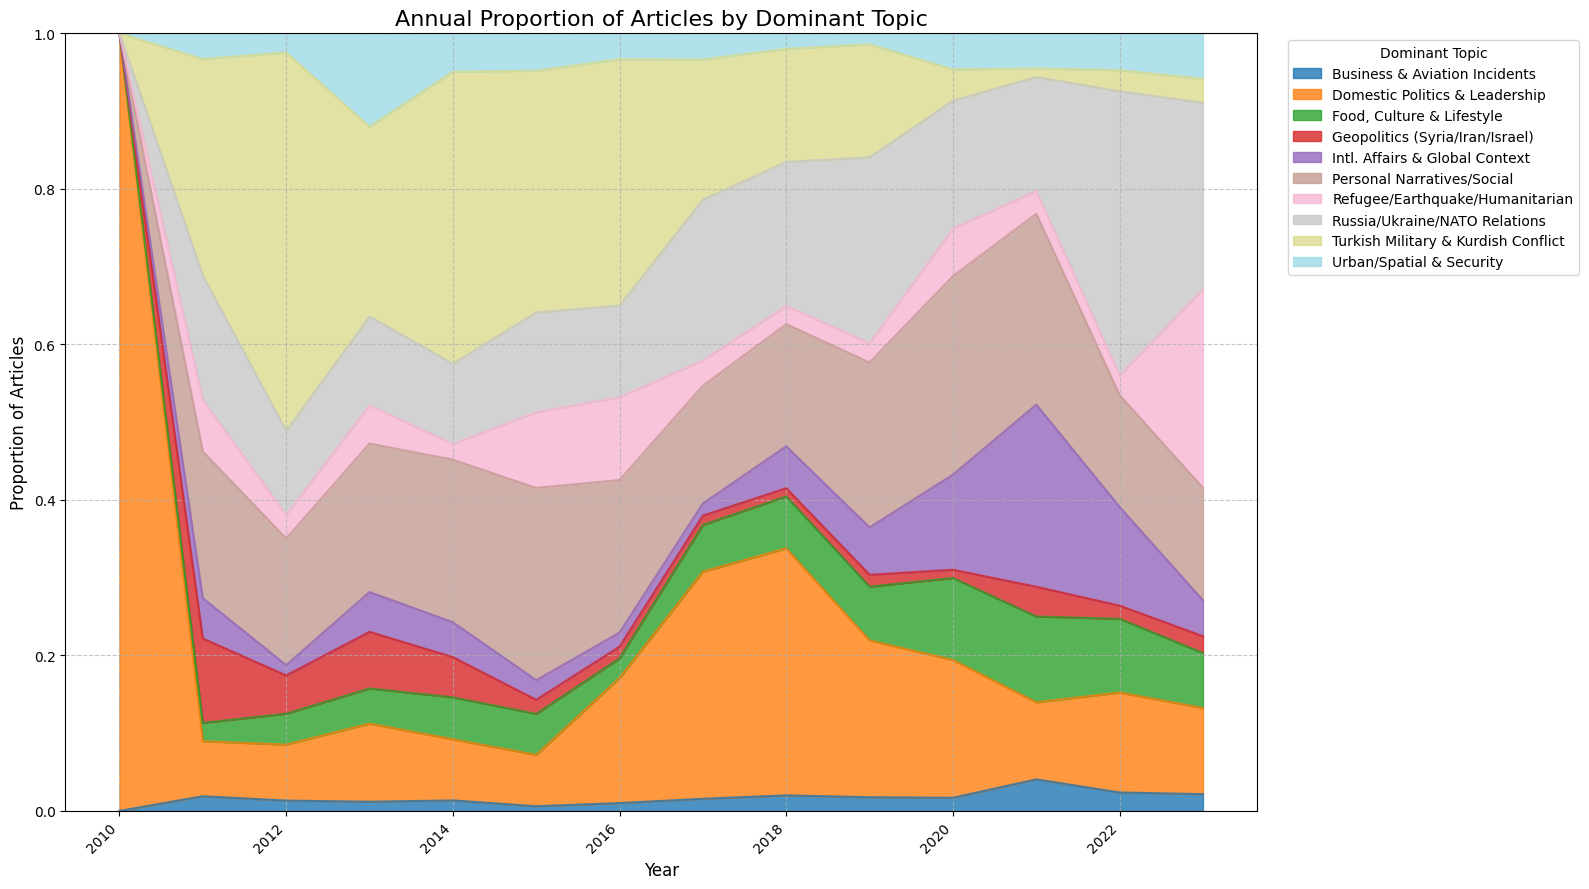


Note: The 'topic_names' dictionary needs to be manually updated with your final interpreted topic names from pyLDAvis (Cell 6).


In [10]:
# -*- coding: utf-8 -*-
# %% [markdown]
# ### Cell 8: Dominant Topics Over Time (Annually)
# This cell visualizes the **annual proportion of articles assigned to each dominant topic**, showing how the media's focus on different themes related to Turkey evolves over time. This helps to understand shifts in the agenda of news outlets.
#
# **IMPORTANT:** This cell relies on `df_with_topics` created in Cell 7.

# %%
if 'df_with_topics' not in locals() or df_with_topics.empty:
    print("Error: 'df_with_topics' DataFrame not found or is empty. Please ensure Cell 7 was run successfully.")
else:
    # Ensure DATE_COLUMN is datetime and drop NaT if any
    DATE_COLUMN = 'date' # Assuming 'date' is still the correct column name
    SOURCE_COLUMN = 'newsSource' # Assuming 'newsSource' is still the correct column name

    df_with_topics[DATE_COLUMN] = pd.to_datetime(df_with_topics[DATE_COLUMN], errors='coerce')
    df_with_topics_cleaned = df_with_topics.dropna(subset=[DATE_COLUMN]).copy()

    if df_with_topics_cleaned.empty:
        print("After cleaning dates, 'df_with_topics_cleaned' is empty. Cannot perform temporal topic analysis.")
    else:
        print("\nVisualizing: Dominant Topics Over Time (Annually Proportion)")

        # Create the Topic_Name mapping (you will manually update this after Cell 6's pyLDAvis output)
        # Use the topic keywords from your LDA model output as temporary labels
        # IMPORTANT: Replace these with your actual interpreted topic names from pyLDAvis (Cell 6)
        # For example: {0: "Middle East Geopolitics", 1: "Turkish Military & Kurdish Conflict", ...}
        topic_names = {
            0: "Geopolitics (Syria/Iran/Israel)",
            1: "Turkish Military & Kurdish Conflict",
            2: "Intl. Affairs & Global Context",
            3: "Domestic Politics & Leadership",
            4: "Urban/Spatial & Security",
            5: "Business & Aviation Incidents",
            6: "Russia/Ukraine/NATO Relations",
            7: "Refugee/Earthquake/Humanitarian",
            8: "Personal Narratives/Social",
            9: "Food, Culture & Lifestyle"
        }
        df_with_topics_cleaned['Dominant_Topic_Name'] = df_with_topics_cleaned['Dominant_Topic'].map(topic_names)


        # Group by year and dominant topic to count articles
        topic_counts_annual = df_with_topics_cleaned.groupby([df_with_topics_cleaned[DATE_COLUMN].dt.year, 'Dominant_Topic_Name']).size().unstack(fill_value=0)

        # Calculate proportions for each year
        topic_proportions_annual = topic_counts_annual.apply(lambda x: x / x.sum(), axis=1)
        topic_proportions_annual.index.name = 'Year'
        topic_proportions_annual.reset_index(inplace=True)

        # Melt the DataFrame for seaborn plotting
        topic_proportions_melted = topic_proportions_annual.melt(id_vars='Year', var_name='Topic', value_name='Proportion')

        plt.figure(figsize=(16, 9))
        sns.set_palette('tab20') # Use a palette with more distinct colors for many topics

        # Use a stacked bar plot or area plot to show proportions over time
        # Stacked bar plot is good for showing composition changes
        topic_proportions_melted.pivot(index='Year', columns='Topic', values='Proportion').plot(
            kind='area', stacked=True, figsize=(16, 9), cmap='tab20', alpha=0.8
        )

        plt.title('Annual Proportion of Articles by Dominant Topic', fontsize=16)
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('Proportion of Articles', fontsize=12)
        plt.ylim(0, 1) # Proportions sum to 1
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(title='Dominant Topic', bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        print("\nNote: The 'topic_names' dictionary needs to be manually updated with your final interpreted topic names from pyLDAvis (Cell 6).")